# Initialization

In [27]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'

# cosmetics for plots 
sns.set(font_scale = 1.5)

In [28]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses)
prescribers = pd.read_csv(file_prescribers)

### A few small cleaning tasks. 

In [29]:
overdoses = overdoses.set_index('State')
overdoses['Population']=overdoses['Population'].str.replace(',', '')
overdoses['Deaths']=overdoses['Deaths'].str.replace(',','')
overdoses[['Population', 'Deaths']]=overdoses[['Population','Deaths']].apply(pd.to_numeric)

# rename column because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);

# add prescriber information to overdose df 
prescribers_per_state = []
for index, row in overdoses.iterrows(): 
    prescribers_per_state.append(prescribers.loc[prescribers['Abbrev']==row['Abbrev']].shape[0])
overdoses['Prescribers'] = prescribers_per_state

# prescribers per capita
overdoses['Prescribers Per Capita'] = overdoses['Prescribers']/overdoses['Population']
# overdoses per capita
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/ overdoses['Population']) * 10000

# The Data Story

## Introduction: the dataset. 

## Questions 
1. Is the opioid overdose rate the same everywhere, or does it depend on the state? Are there US regions/divisions that are associated with a higher rate of overdose? 
2. Is the overdose rate related to the number of prescribers per capita? 
3. Which types of providers prescribe the most opioids? Why? 
4. Can we characterize provider specialties based on the drugs they prescribe in a year?

## Question 1: Is the opioid overdose rate the same everywhere, or does it depend on the state?

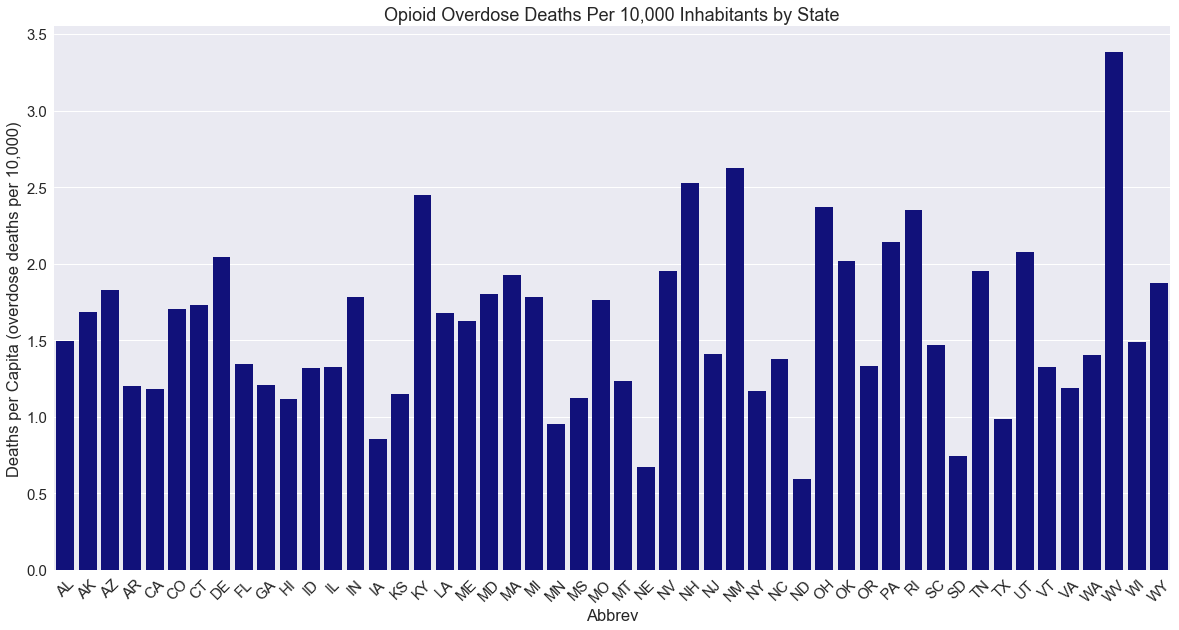

In [32]:
_ = plt.subplots(figsize=(20,10))
dpc_bar = sns.barplot(x = 'Abbrev', y='Deaths Per Capita', data = overdoses, color = 'darkblue')
_ = dpc_bar.set_xticklabels(overdoses.Abbrev, rotation = 45)
_ = dpc_bar.set_ylabel('Deaths per Capita (overdose deaths per 10,000)')
_ = dpc_bar.set_title('Opioid Overdose Deaths Per 10,000 Inhabitants by State')

In [34]:
max_deaths = overdoses['Deaths'].max()
max_deaths_per_capita=overdoses['Deaths Per Capita'].max()
min_deaths_per_capita=overdoses['Deaths Per Capita'].min()
print('Max Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==max_deaths_per_capita])
print('-'*100)
print('Max Deaths')
print(overdoses.loc[overdoses['Deaths']==max_deaths])
print('-'*100)
print('Min Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==min_deaths_per_capita])
print('-'*100)
print('Descriptions')
print(overdoses['Deaths'].describe())
print(overdoses['Deaths Per Capita'].describe())

Max Deaths Per Capita
               Population  Deaths Abbrev  Prescribers  Prescribers Per Capita  \
State                                                                           
West Virginia     1854304     627     WV          199                0.000107   

               Deaths Per Capita  
State                             
West Virginia           3.381323  
----------------------------------------------------------------------------------------------------
Max Deaths
            Population  Deaths Abbrev  Prescribers  Prescribers Per Capita  \
State                                                                        
California    38332521    4521     CA         2562                0.000067   

            Deaths Per Capita  
State                          
California           1.179416  
----------------------------------------------------------------------------------------------------
Min Deaths Per Capita
              Population  Deaths Abbrev  Prescribers  Prescribe

In [36]:
tracked_drugs = list(prescribers.columns)[5:-1]

def provider_drugs(npi, df= prescribers, track_list = tracked_drugs):
    '''
    Given a provider NPI, returns a list of the drugs the provider prescribed
    Grabs this info from the prescribers database unless otherwise instructed, 
    Grabs info about which drugs are being tracked from tracked_drugs (built from prescribers)
    unless otherwise noted. 
    
    With track_list = detected_opioids, this returns the (recognized) opioids the provdier has prescribed! :)
    '''
    row = df[prescribers.NPI==npi]
    all_drugs = row[track_list].transpose()
    all_drugs.columns = ['num_prescriptions']
    return list(all_drugs.iloc[all_drugs.num_prescriptions.nonzero()].index)

prescribers['prescribed_drugs'] = prescribers['NPI'].apply(provider_drugs)

## Question 4: Can we characterize provider specialties based on the drugs they prescribe in a year?

In [37]:
def make_samples(val_list, col = 'Specialty', data_columns = tracked_drugs + ['Opioid.Prescriber'], 
                source_df = prescribers):
    '''
    INPUT: val_list, a list of values found in col 
           col, a string designating a column from source_df 
           data_columns, column names containing data we want in our sample
           source_df, the dataframe from which we're pulling data 
           
    '''
    samples = source_df[source_df[col].isin(val_list)][data_columns]
    return samples 

from sklearn.manifold import TSNE

In [41]:
# first try with two different prescribers...
from sklearn.manifold import TSNE
sample_drugs = prescribers[prescribers.Specialty.isin(['Optometry', 'Vascular Surgery'])]['prescribed_drugs']
sample_drugs = list(set([drug for sublist in sample_drugs for drug in sublist]))
samples = make_samples(['Optometry', 'Vascular Surgery'], data_columns = sample_drugs + ['Specialty'])
model = TSNE(learning_rate = 200)
transformed = model.fit_transform(samples[sample_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

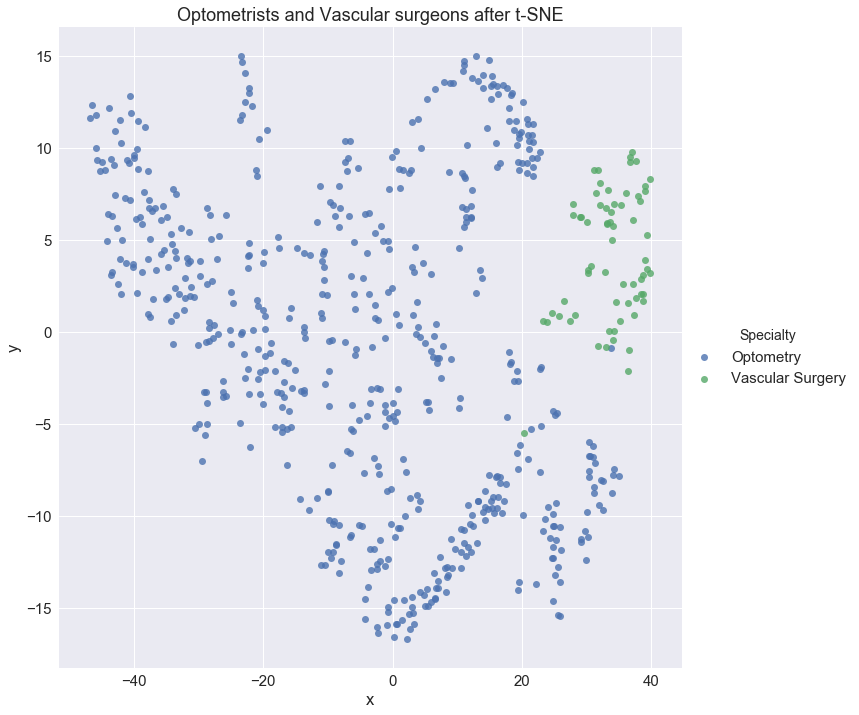

In [42]:
_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Optometrists and Vascular surgeons after t-SNE')

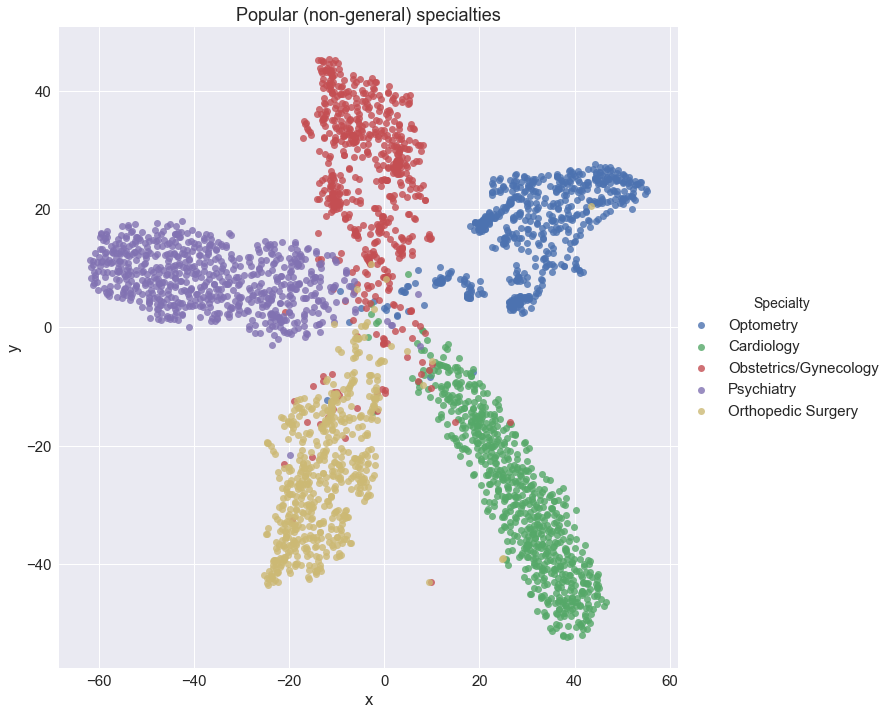

In [43]:
very_popular_specializations = ['Psychiatry', 'Cardiology', 'Obstetrics/Gynecology', 'Orthopedic Surgery', 'Optometry', 'Opthalmology']

samples_popular = make_samples(very_popular_specializations, data_columns = tracked_drugs + ['Specialty'])
model = TSNE(learning_rate = 500, perplexity=50)
transformed_popular = model.fit_transform(samples_popular[tracked_drugs])
xs = transformed_popular[:,0]
ys = transformed_popular[:,1]

trans_df_popular = pd.DataFrame(transformed_popular, columns = ['x', 'y'])
trans_df_popular = trans_df_popular.reset_index(drop=True)
sample_labels_popular = samples_popular.Specialty.reset_index(drop=True)
trans_df_popular= pd.concat([trans_df_popular, sample_labels_popular], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df_popular, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Popular (non-general) specialties')

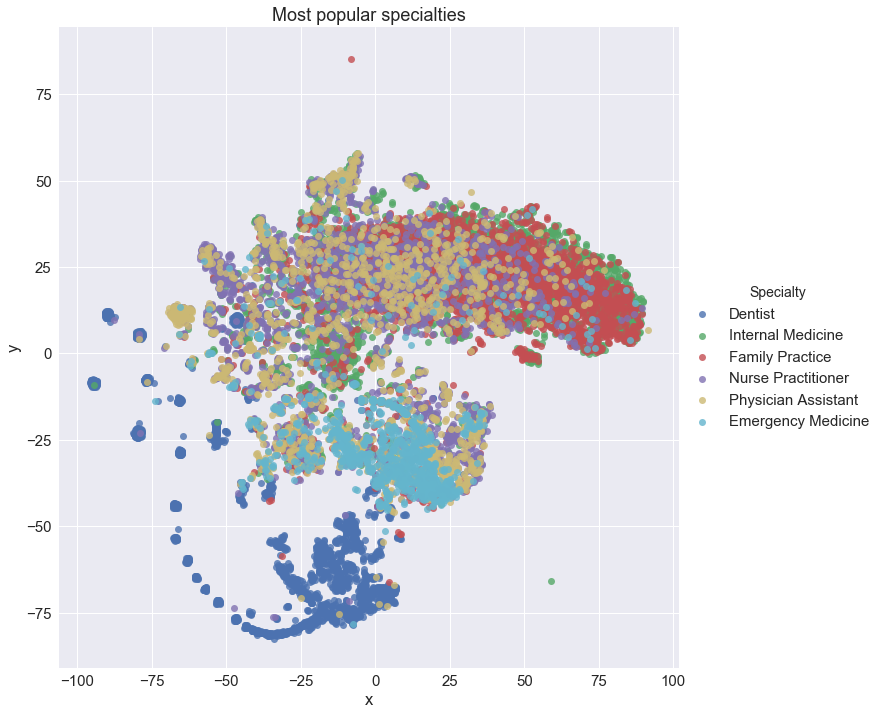

In [45]:
specialty_counts = prescribers.Specialty.value_counts()
most_popular = list(specialty_counts[specialty_counts > 1000].index)
samples = make_samples(most_popular, data_columns = tracked_drugs + ['Specialty'])
model = TSNE(learning_rate = 500, perplexity=50)
transformed = model.fit_transform(samples[tracked_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Most popular specialties')

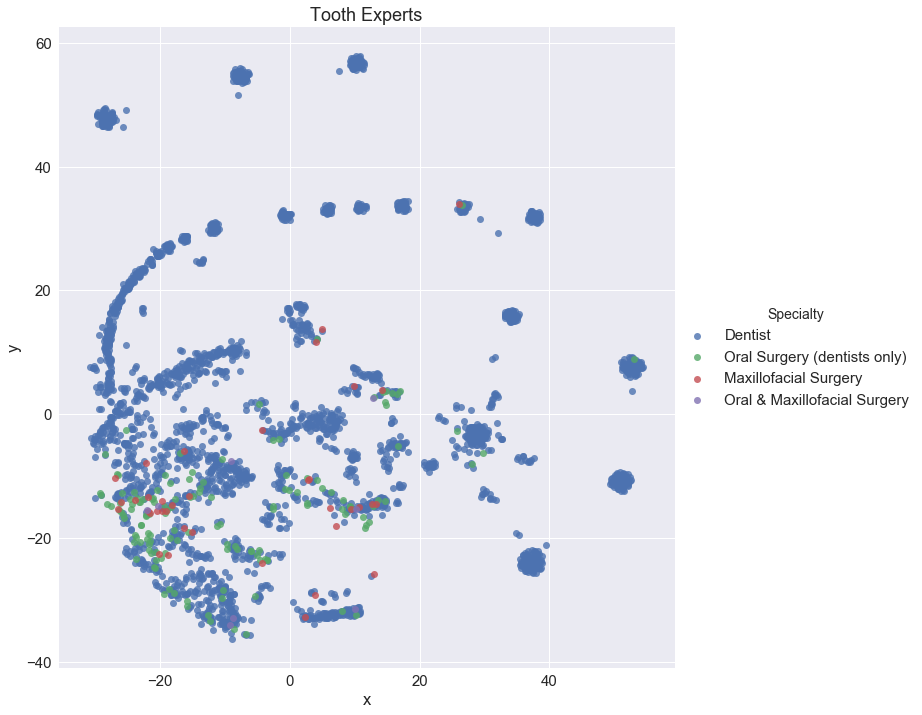

In [46]:
tooth_experts = ['Maxillofacial Surgery', 'Dentist', 'Oral & Maxillofacial Surgery','Oral Surgery (dentists only)']
tooth_samples = make_samples(tooth_experts, data_columns = tracked_drugs + ['Specialty'])
tooth_model = TSNE(learning_rate = 500, perplexity=30)
tooth_transformed = model.fit_transform(tooth_samples[tracked_drugs])
xs = tooth_transformed[:,0]
ys = tooth_transformed[:,1]

tooth_trans_df = pd.DataFrame(tooth_transformed, columns = ['x', 'y'])
tooth_trans_df = tooth_trans_df.reset_index(drop=True)
tooth_sample_labels = tooth_samples.Specialty.reset_index(drop=True)
tooth_trans_df= pd.concat([tooth_trans_df, tooth_sample_labels], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=tooth_trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Tooth Experts')